# This notebook contains the code which prepares training and test datasets for a dummy model, as well as trains and evaluates the dummy model


## Connect the notebook to MyDrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Standard python libraries for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NLP packages for text processing
from spacy.lang.en import English
import spacy
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Libraries to build, train, evaluate, and save an ML model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import pickle

## Initialize nlp instance and download necessary resources


To be able to use statistical English language models for processing textual data we might need to download them first. <br>
To train the dummy model I used a small statistical model with a 12MB size. <br>
To download the small model you need to run the following command in the code cell: `!python -m spacy download en_core_web_sm`

In [6]:
nlp = English()
nlp = spacy.load('en_core_web_sm') # smaller model

## Load train and test datasets

In [7]:
# Import train dataset into pandas DataFrame
train_df = pd.read_csv("drive/MyDrive/python_project/data/train_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(train_df.head())

# Import test dataset into pandas DataFrame
test_df = pd.read_csv("drive/MyDrive/python_project/data/test_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(test_df.head())

                                            dialogue     name
0                                   Until half time.    Penny
1   Oh, I’m not buying anything. They’re having a...  Sheldon
2                                          No, here.   Howard
3   Under normal circumstances I’d say, I told yo...  Sheldon
4   Why don’t we all stop hitting ourselves and t...    Penny
                              dialogue     name
0                        Your clothes?  Sheldon
1                 Penny, are you okay?  Leonard
2              Thinly veiled contempt.    Penny
3    Well, which is it, ten or eleven?    Penny
4   I did not force you to go to that.  Leonard


## Get features for the dummy model

The feature for our dummy model is top 10 unique nouns

In [8]:
# Create a dictionary to store noun frequencies per name
noun_freq_per_name = {}

# Iterate over each name in the DataFrame
for name in train_df['name'].unique():
    # Get the dialogue texts for the current name
    dialogues = train_df.loc[train_df['name'] == name, 'dialogue']

    # Tokenize, lemmatize, and extract nouns
    all_nouns = []
    for dialogue in dialogues:
        # Remove punctuation using regex
        dialogue = re.sub(r'[^\w\s]', '', str(dialogue))

        doc = nlp(dialogue.lower())  # Make tokens lowercase
        nouns = [
            token.lemma_
            for token in doc
            if token.pos_ == 'NOUN'
            and token.lemma_.lower() not in STOP_WORDS
        ]
        all_nouns.extend(nouns)

    # Calculate the noun frequencies
    noun_freq = Counter(all_nouns)

    # Store the noun frequencies for the current name
    noun_freq_per_name[name] = noun_freq.most_common(10)

# Print the 10 most common nouns per name
for name, freq_nouns in noun_freq_per_name.items():
    print(f"10 most common nouns for {name}:")
    for noun, freq in freq_nouns:
        print(f"- {noun}: {freq}")
    print()

10 most common nouns for Penny:
- sheldon: 209
- guy: 160
- thing: 124
- time: 91
- friend: 85
- let: 62
- night: 61
- people: 56
- leonard: 56
- girl: 53

10 most common nouns for Sheldon:
- time: 192
- penny: 174
- knock: 114
- thing: 113
- people: 99
- friend: 81
- day: 77
- course: 76
- way: 75
- man: 74

10 most common nouns for Howard:
- guy: 129
- sheldon: 127
- time: 103
- thing: 94
- mother: 82
- space: 80
- way: 79
- mom: 78
- woman: 72
- girl: 59

10 most common nouns for Leonard:
- sheldon: 212
- penny: 143
- guy: 122
- time: 104
- thing: 90
- way: 62
- night: 59
- friend: 59
- people: 49
- let: 46



## Get unique nouns

In [14]:
# Get all the values of the noun_freq_per_name dictionary which are tuple of nouns and their frequencies
noun_freq_list = noun_freq_per_name.values()
# noun_freq_list is the list of lists of  noun + frequency tuples
# To get only nouns without frequencies we need to iterate through the list of lists of noun + frequency tuples and then through lists of noun + frequency tuples and get the first element of the tuple
# For this we used a list comprehension
freq_nouns = [noun_freq[0] for noun_freqs in noun_freq_list for noun_freq in noun_freqs]
# To get only unique nouns we cast the list of nouns into a set and then cast it back to a list
unique_freq_nouns = list(set(freq_nouns))
# Print the list and length of unique nouns
print(unique_freq_nouns)
print(len(unique_freq_nouns))

['people', 'guy', 'thing', 'night', 'friend', 'man', 'girl', 'leonard', 'sheldon', 'day', 'time', 'mother', 'space', 'way', 'knock', 'mom', 'course', 'woman', 'let', 'penny']
20


## Prepare train and test datasets for the dummy model


In [15]:
# Get a list of dialogues and names from the train dataset
train_dialogues = train_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
train_names = train_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(train_dialogues[:5])
print(train_names[:5])

# Get a list of dialogues and names from the test dataset
test_dialogues = test_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
test_names = test_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(test_dialogues[:5])
print(test_names[:5])

[' until half time.', ' oh, i’m not buying anything. they’re having a lecture. h-o gauge railroading. half the size of o-gauge, but twice the fun. very controversial topic.', ' no, here.', ' under normal circumstances i’d say, i told you so. but as i have told you so with such vehemence and frequency already, the phrase has lost all meaning. therefore, i will be replacing it with the phrase i informed you thusly.', ' why don’t we all stop hitting ourselves and talk about something safe, you know, like shoes or how cute little chinese babies are.']
['penny', 'sheldon', 'howard', 'sheldon', 'penny']
[' your clothes?', ' penny, are you okay?', ' thinly veiled contempt.', ' well, which is it, ten or eleven?', ' i did not force you to go to that.']
['sheldon', 'leonard', 'penny', 'penny', 'leonard']


In [16]:
# Get train numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
train_features = np.zeros((len(train_dialogues), len(unique_freq_nouns)))

# Print the shape of this 2d array
print(train_features.shape)

# Get test numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
test_features = np.zeros((len(test_dialogues), len(unique_freq_nouns)))

# Print the shape of this 2d array
print(test_features.shape)

(18468, 20)
(4596, 20)


Fill in the train_features and test_features with 1 if the unique noun exists in the dialogue


In [17]:
# Initialize a train_doc_dialogues generator
train_doc_dialogues = nlp.pipe(train_dialogues)

# Iterate throguh train_doc_dialogues generator and train_features numpy array
for dialogue, f in zip(train_doc_dialogues, train_features):
    # create a tokens list of all words in the dialogue
    tokens_list = [token.lemma_ for token in dialogue]
    # iterate through the list of unique nouns
    for noun in unique_freq_nouns:
        # if the noun in the tokens list
        if noun in tokens_list:
            # get the index number of the noun in the unique nouns list
            noun_id = unique_freq_nouns.index(noun)
            # replace the value of the feature array at the given index with 1
            f[noun_id] = 1

In [20]:
# Initialize a test_doc_dialogues generator
test_doc_dialogues = nlp.pipe(test_dialogues )

# Iterate throguh test_doc_dialogues generator and test_features numpy array
for dialogue, f in zip(test_doc_dialogues, test_features):
    # create a tokens list of all words in the dialogue
    tokens_list = [token.lemma_ for token in dialogue]
    # iterate through the list of unique nouns
    for noun in unique_freq_nouns:
        # if the noun in the tokens list
        if noun in tokens_list:
            # get the index number of the noun in the unique nouns list
            noun_id = unique_freq_nouns.index(noun)
            # replace the value of the feature array at the given index with 1
            f[noun_id] = 1

## Train the dummy model

In [23]:
# Make an instance of the Model from LogisticRegression class
lr_dummy_model = LogisticRegression(verbose=2)

# Train the model
lr_dummy_model.fit(train_features, train_names)

# Print the labels
print(lr_dummy_model.classes_)

# Print parameters of the model
print(lr_dummy_model.get_params())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


['howard' 'leonard' 'penny' 'sheldon']
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 2, 'warm_start': False}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


## Save the dummy model

In [24]:
with open("drive/MyDrive/python_project/lr_dummy_model.pkl", 'wb') as file:
    pickle.dump(lr_dummy_model, file)

## Get prdictions

In [27]:
# Define a funtion that will take the index of the dialogue in the test features and predict the name to whom this dialogue might belong
def getPrediction(index):
    name = lr_dummy_model.predict([test_features[index]])
    return name

# Predict the label
print(f"The dummy model predicted: {getPrediction(9)}")
# Print the correct label
print(f"The correct class is: {test_names[9]}")
# Predict the label but also tell us the probabilities for predicting each possible label
print(f"Here are the probablities of the dialogue belonging to each class: {lr_dummy_model.predict_proba([test_features[9]])}")

# Let's see what are the possible labels to predict (and in which order they are stored)
print(f"Here are the classes: {lr_dummy_model.classes_}")

The dummy model predicted: ['leonard']
The correct class is: sheldon
Here are the probablities of the dialogue belonging to each class: [[0.25100632 0.25630508 0.24949946 0.24318914]]
Here are the classes: ['howard' 'leonard' 'penny' 'sheldon']


## Evaluate the dummy model

### Accuracy

In [48]:
# Get prediction of all dialogues
predictions = lr_dummy_model.predict(test_features)
# Use accuracy_score funtion to calculate the accuracy
accuracy = accuracy_score(test_names, predictions)
# Print the accuracy
print("Accuracy of the dummy model:", accuracy)

Accuracy of the dummy model: 0.28263707571801566


### Confusion matrix vusialisation

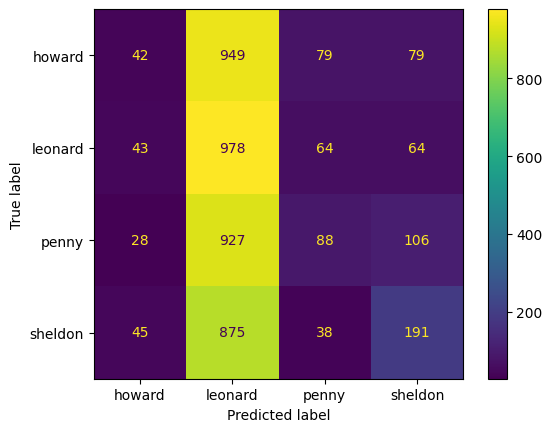

In [45]:
# Get the labels
labels = lr_dummy_model.classes_
# Get the confusion matrix
cm = confusion_matrix(test_names, predictions, labels=labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Get the classification report

In [47]:
# Print the classification report
print(classification_report(test_names, predictions))

              precision    recall  f1-score   support

      howard       0.27      0.04      0.06      1149
     leonard       0.26      0.85      0.40      1149
       penny       0.33      0.08      0.12      1149
     sheldon       0.43      0.17      0.24      1149

    accuracy                           0.28      4596
   macro avg       0.32      0.28      0.21      4596
weighted avg       0.32      0.28      0.21      4596

